Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading image...
Image loaded. Size: (426, 640)

Applying averaging filters...


/tmp/ipython-input-620971468.py:17: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(arr, mode='L').save(path)


✓ avg3.png saved (3×3 averaging filter)
✓ avg7.png saved (7×7 averaging filter)

Applying Laplacian filter...


/tmp/ipython-input-620971468.py:85: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(lap_disp, mode='L').save(os.path.join(output_dir, 'laplacian_response.png'))


✓ laplacian_response.png saved (edge detection)
✓ laplacian_sharpened.png saved (sharpened image)
✓ original_grayscale.png saved

Processing complete!
All files saved to: /content/drive/MyDrive/Colab Notebooks/output

Displaying results...

--- Original Image ---


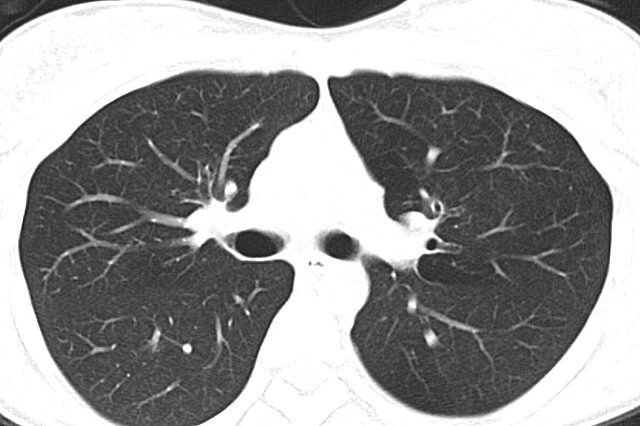


--- 3×3 Averaging Filter ---


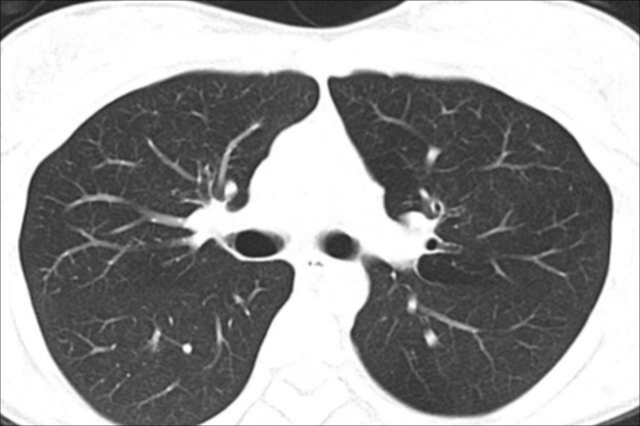


--- 7×7 Averaging Filter ---


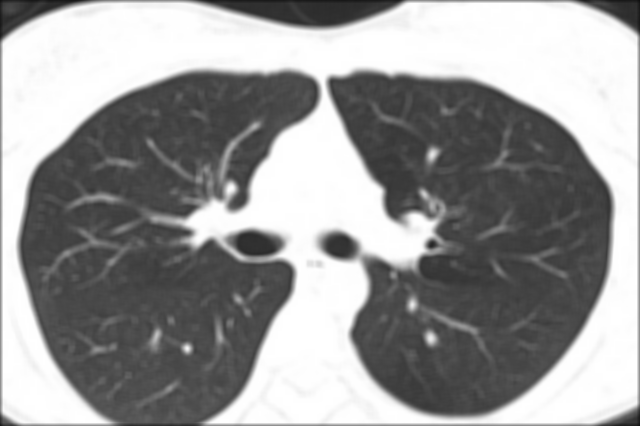


--- Laplacian Edge Detection ---


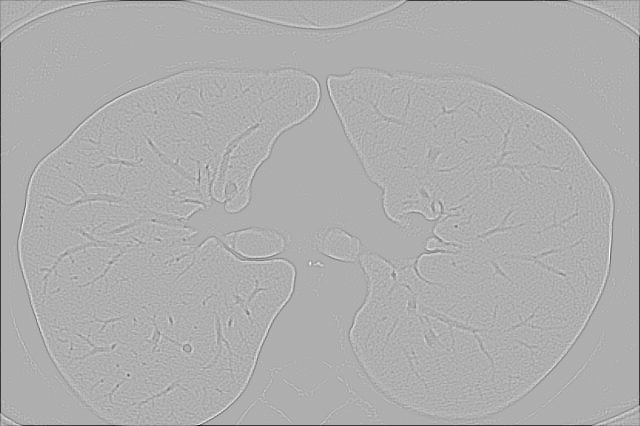


--- Laplacian Sharpened ---


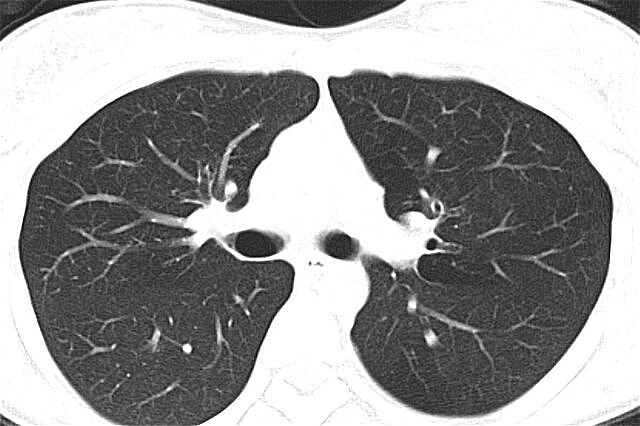

In [5]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import os


def to_grayscale_np(path):
    """Load image as grayscale float32 array in [0,255]."""
    img = Image.open(path).convert('L')
    return np.asarray(img, dtype=np.float32)


def save_uint8(arr, path):
    """Save array as uint8 image, clipping to [0, 255]."""
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    Image.fromarray(arr, mode='L').save(path)


def rescale_to_uint8(arr):
    """Rescale array to [0, 255] for display purposes."""
    a_min, a_max = arr.min(), arr.max()
    if a_max == a_min:
        return np.zeros_like(arr, dtype=np.uint8)
    arr_norm = (arr - a_min) / (a_max - a_min) * 255.0
    return arr_norm.astype(np.uint8)


def manual_convolve_same(image, kernel):
    """Manual convolution with zero padding (same size output)."""
    kh, kw = kernel.shape
    assert kh % 2 == 1 and kw % 2 == 1, "Kernel must have odd dimensions."
    pad_h, pad_w = kh // 2, kw // 2
    H, W = image.shape
    padded = np.zeros((H + 2*pad_h, W + 2*pad_w), dtype=np.float32)
    padded[pad_h:pad_h+H, pad_w:pad_w+W] = image
    # flip kernel for convolution
    kflip = kernel[::-1, ::-1].astype(np.float32)
    out = np.zeros_like(image, dtype=np.float32)
    for i in range(H):
        for j in range(W):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kflip)
    return out


def averaging_kernel(k):
    """Create k×k averaging kernel."""
    return np.ones((k, k), dtype=np.float32) / float(k * k)


# Main processing code
image_path = "/content/drive/MyDrive/Colab Notebooks/lung_ct.jpg"
output_dir = "/content/drive/MyDrive/Colab Notebooks/output"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Load image
print("Loading image...")
img = to_grayscale_np(image_path)
print(f"Image loaded. Size: {img.shape}")

# Averaging filters
print("\nApplying averaging filters...")
k3 = averaging_kernel(3)
k7 = averaging_kernel(7)
avg3 = manual_convolve_same(img, k3)
avg7 = manual_convolve_same(img, k7)
save_uint8(avg3, os.path.join(output_dir, 'avg3.png'))
save_uint8(avg7, os.path.join(output_dir, 'avg7.png'))
print("✓ avg3.png saved (3×3 averaging filter)")
print("✓ avg7.png saved (7×7 averaging filter)")

# Standard Laplacian filter (isotropic, 8-neighbor)
print("\nApplying Laplacian filter...")
lap = np.array([[1, 1, 1],
                [1, -8, 1],
                [1, 1, 1]], dtype=np.float32)

lap_resp = manual_convolve_same(img, lap)

# Save a displayable version (rescaled to [0, 255])
lap_disp = rescale_to_uint8(lap_resp)
Image.fromarray(lap_disp, mode='L').save(os.path.join(output_dir, 'laplacian_response.png'))
print("✓ laplacian_response.png saved (edge detection)")

# Sharpening: original - alpha * Laplacian
alpha = 0.1
sharpen = img - alpha * lap_resp
save_uint8(sharpen, os.path.join(output_dir, 'laplacian_sharpened.png'))
print("✓ laplacian_sharpened.png saved (sharpened image)")

# Also save the original for convenience
save_uint8(img, os.path.join(output_dir, 'original_grayscale.png'))
print("✓ original_grayscale.png saved")

print(f"\n{'='*50}")
print(f"Processing complete!")
print(f"All files saved to: {output_dir}")
print(f"{'='*50}")

# Display results in Colab
from google.colab.patches import cv2_imshow
import cv2

print("\nDisplaying results...")
print("\n--- Original Image ---")
cv2_imshow(cv2.imread(os.path.join(output_dir, 'original_grayscale.png'), 0))

print("\n--- 3×3 Averaging Filter ---")
cv2_imshow(cv2.imread(os.path.join(output_dir, 'avg3.png'), 0))

print("\n--- 7×7 Averaging Filter ---")
cv2_imshow(cv2.imread(os.path.join(output_dir, 'avg7.png'), 0))

print("\n--- Laplacian Edge Detection ---")
cv2_imshow(cv2.imread(os.path.join(output_dir, 'laplacian_response.png'), 0))

print("\n--- Laplacian Sharpened ---")
cv2_imshow(cv2.imread(os.path.join(output_dir, 'laplacian_sharpened.png'), 0))
